# Multi-Station NEXRAD Reflectivity Plot Over Tennessee with Py-ART and AWS S3

This notebook retrieves and visualizes NEXRAD Level II radar reflectivity data for stations across Tennessee.

It automatically fetches the most recent available data from the `noaa-nexrad-level2` AWS S3 bucket, processes it using Py-ART, and renders it on a Cartopy map with detailed county and state boundaries. If data is unavailable for any station, the map will indicate that the radar is offline with a clear placeholder annotation.

## 📦 Step 1: Import Required Libraries

In [1]:
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
from metpy.plots import colortables, USCOUNTIES
import numpy as np
import boto3
import tempfile
import os
import re
import pyart
from botocore import UNSIGNED
from botocore.client import Config


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## 🔧 Step 2: Define Utility Functions
These helper functions handle file listing, radar timestamp parsing, file downloading, and radar data extraction.

In [2]:
def list_files(bucket_name, prefix):
    s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    paginator = s3_client.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket_name, Prefix=prefix)
    files = []
    for page in page_iterator:
        if 'Contents' in page:
            for item in page['Contents']:
                files.append(item['Key'])
    return files

def get_datetime_from_filename(filename, station):
    match = re.match(rf'^{station}([0-9]{{8}})_([0-9]{{6}})_V06', filename)
    if match:
        date_str = match.group(1)
        time_str = match.group(2)
        datetime_str = date_str + time_str
        dt = datetime.strptime(datetime_str, '%Y%m%d%H%M%S')
        return dt
    return None

def find_closest_file(files_times, desired_time):
    min_diff = timedelta.max
    closest_file = None
    for key, file_time in files_times:
        diff = abs(file_time - desired_time)
        if diff < min_diff:
            min_diff = diff
            closest_file = key
    return closest_file

def download_file(bucket_name, key):
    s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    tmp = tempfile.NamedTemporaryFile(delete=False)
    s3_client.download_fileobj(bucket_name, key, tmp)
    tmp.close()
    return tmp.name

def fetch_radar_data(station, date):
    bucket_name = 'noaa-nexrad-level2'
    prefix = f"{date:%Y/%m/%d}/{station}/"
    files = list_files(bucket_name, prefix)

    files_times = []
    for key in files:
        filename = os.path.basename(key)
        file_dt = get_datetime_from_filename(filename, station)
        if file_dt:
            files_times.append((key, file_dt))

    closest_file_key = find_closest_file(files_times, date)
    if not closest_file_key:
        # Try the previous day
        prev_date = date - timedelta(days=1)
        prefix = f"{prev_date:%Y/%m/%d}/{station}/"
        files = list_files(bucket_name, prefix)
        files_times = []
        for key in files:
            filename = os.path.basename(key)
            file_dt = get_datetime_from_filename(filename, station)
            if file_dt:
                files_times.append((key, file_dt))
        closest_file_key = find_closest_file(files_times, date)
        if not closest_file_key:
            return None, None

    file_path = download_file(bucket_name, closest_file_key)
    return file_path, closest_file_key


## ☁️ Step 3: Define the Plotting Function
This function fetches radar data for each station and plots the reflectivity over a Tennessee map. If a radar is offline, a message is plotted instead. 

In [3]:
def plot_tennessee_radar():
    stations = ['KNQA', 'KOHX', 'KMRX']
    date = datetime.utcnow()

    fig = plt.figure(figsize=(12, 10), facecolor='white')
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_facecolor('white')
    ax.set_extent([-90.5, -81.5, 34.5, 37], crs=ccrs.PlateCarree())

    cmap = colortables.get_colortable('NWSStormClearReflectivity')
    valid_times = []
    img = None

    for station in stations:
        file_path, closest_file_key = fetch_radar_data(station, date)
        if not file_path:
            print(f"No data found for station {station}")
            station_coords = {
                'KNQA': (-89.87, 35.34),
                'KOHX': (-86.56, 36.24),
                'KMRX': (-83.99, 36.17)
            }
            lon, lat = station_coords.get(station, (-85, 35.5))
            ax.text(lon, lat, f"{station}\nRADAR OFFLINE", color='red',
                    fontsize=9, ha='center', va='center', zorder=20,
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='red'))
            continue

        try:
            radar = pyart.io.read_nexrad_archive(file_path)
            sweep = 0
            ref = radar.get_field(sweep, 'reflectivity')
            gate_lats, gate_lons, gate_alts = radar.get_gate_lat_lon_alt(sweep)

            img = ax.pcolormesh(gate_lons, gate_lats, ref, cmap=cmap, vmin=-30, vmax=80, zorder=5)

            start_time = radar.time['units'].split(' ')[-1]
            start_dt = datetime.strptime(start_time, '%Y-%m-%dT%H:%M:%SZ')
            valid_times.append(start_dt)

            os.remove(file_path)
        except Exception as e:
            print(f"Error processing {station}: {e}")
            os.remove(file_path)
            continue

    ax.add_feature(USCOUNTIES.with_scale('500k'), facecolor='none', edgecolor='gray', linewidth=0.5, zorder=10)
    state_shp = shpreader.natural_earth(resolution='50m', category='cultural', name='admin_1_states_provinces')
    state_reader = shpreader.Reader(state_shp)
    for state in state_reader.records():
        ax.add_geometries([state.geometry], ccrs.PlateCarree(),
                          facecolor='none', edgecolor='black', linewidth=1, zorder=11)

    if img:
        cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.01, aspect=50)
        cbar.set_label('Reflectivity (dBZ)')

    ax_pos = ax.get_position()
    fig.text(ax_pos.x0, ax_pos.y1 + 0.01, 'NEXRAD Base Reflectivity - Tennessee',
             fontsize=14, verticalalignment='bottom', fontweight='bold', color='black')
    if valid_times:
        latest_time = max(valid_times).strftime('%Y-%m-%d %H:%M UTC')
        fig.text(ax_pos.x1, ax_pos.y1 + 0.01, f'Valid: {latest_time}',
                 fontsize=10, verticalalignment='bottom', horizontalalignment='right', color='black')

    plt.show()


## 🗺️ Step 4: Run the Radar Plot!

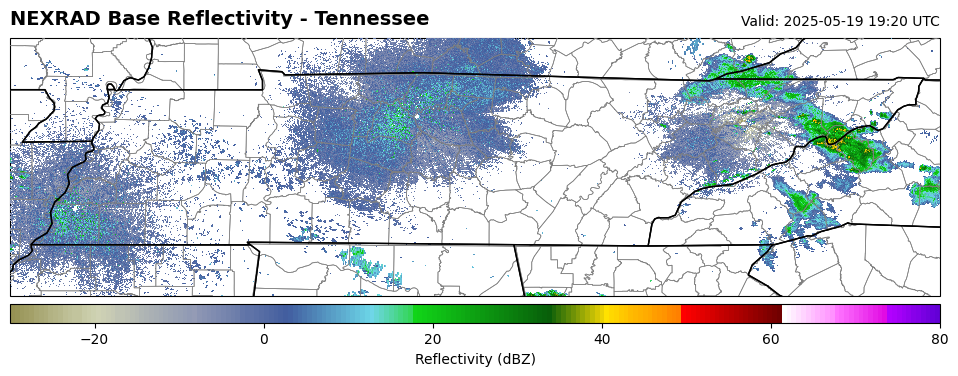

In [4]:
plot_tennessee_radar()